In [1]:
import torch

from TrainingFramework import TrainingFramework, plot_hist, end_of_hist_result
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## ConvArch1

In [2]:
class ConvArch1(nn.Module):
    
    def __init__(self, weight_sharing=False, auxiliary_loss=False):
        
        super(ConvArch1, self).__init__()
        
        self.weight_sharing = weight_sharing
        self.auxiliary_loss = auxiliary_loss
        
        # Create first pipe
        self.pipe1 = self.__create_pipe()
        self.pipe_classifier_1 = self.__create_pipe_classifier()

        # Depending on WS, create second pipe or use the same
        if self.weight_sharing:
            self.pipe2 = self.pipe1
            self.pipe_classifier_2 = self.pipe_classifier_1
        else:
            self.pipe2 = self.__create_pipe()
            self.pipe_classifier_2 = self.__create_pipe_classifier()
        
        # Create final classifier
        self.classifier = self.__create_classifier()
        

    def forward(self, x):        
        x1 = x[:,0:1,:,:]
        x2 = x[:,1:2,:,:]
        x1_pipe = self.pipe_classifier_1(self.pipe1(x1).view(-1, self.pipe_out_dim))
        x2_pipe = self.pipe_classifier_2(self.pipe2(x2).view(-1, self.pipe_out_dim))
        x_main = torch.cat([x1_pipe, x2_pipe], dim=1)
        x_main = self.classifier(x_main)
        
        if self.auxiliary_loss:
            return x_main, (x1_pipe, x2_pipe)
        else:
            return x_main
  

    def __create_pipe(self): 
        # Define output dimension of pipes
        self.pipe_out_dim = 64
        return nn.Sequential(
                nn.Conv2d(1, 16, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.Conv2d(16, 32, kernel_size=3),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(True),
                nn.Conv2d(64, 64, kernel_size=3),
                nn.ReLU(True),
                nn.MaxPool2d(kernel_size=4, stride=4)   
            )
    
    
    def __create_pipe_classifier(self): 
        return nn.Sequential(
                nn.Linear(64, 100),
                nn.ReLU(True),
                nn.Linear(100, 10)
            )
    
    
    def __create_classifier(self):
        return nn.Sequential(
                nn.Linear(20, 32),
                nn.ReLU(True),
                nn.Linear(32, 2)
            )

### No weight sharing, no auxiliary loss

In [3]:
tfNN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=None)
hNN, tNN = tfNN.validateModel(ConvArch1)

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000198,1.0,0.757898,0.8477,NaN,NaN,NaN,NaN,49
best,0.000860,1.0,0.677023,0.8486,NaN,NaN,NaN,NaN,40


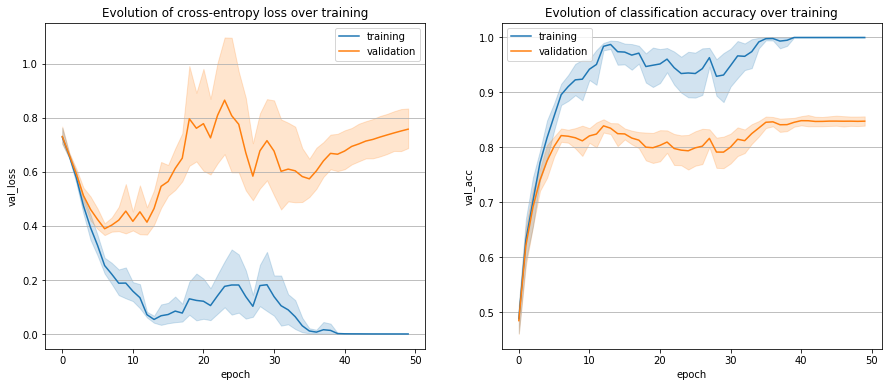

[52.67104389699671, 52.10145217399986, 52.69878653100022, 51.76844937900023, 51.20052258400392, 50.99154656500468, 51.64884688600432, 51.422071493005205, 51.65990478700405, 52.02390919900063]


In [11]:
#hNN.to_csv('./histories/conv_noWS_noAux.csv', encoding='utf-8')
plot_hist(hNN, auxloss=False, savefig='conv_noWS_noAux')
print(tNN)

### Weight sharing, no auxiliary loss

In [5]:
tfYN = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=None)
hYN, tYN = tfYN.validateModel(lambda: ConvArch1(weight_sharing=True))

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000043,1.0,0.858145,0.8656,NaN,NaN,NaN,NaN,49
best,0.000053,1.0,0.844423,0.8656,NaN,NaN,NaN,NaN,44


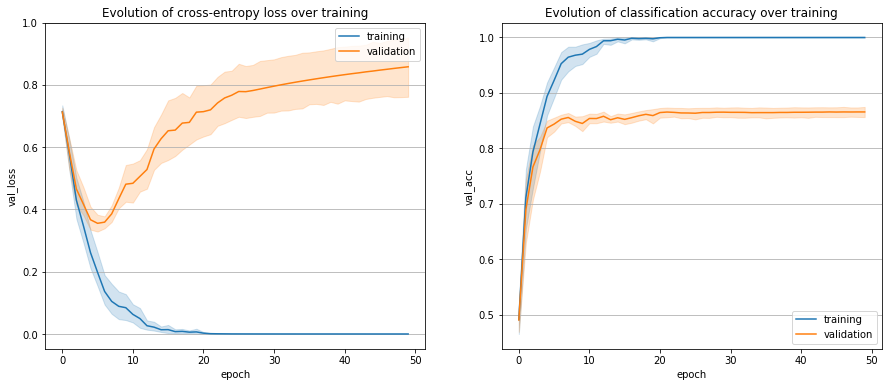

[53.14204042200436, 51.34034339500067, 51.236673314000654, 54.72353798599943, 50.1483376210017, 50.48675090400502, 50.59670269799972, 50.45462423499703, 49.82817730899842, 50.50490790999902]


In [12]:
#hYN.to_csv('./histories/conv_yesWS_noAux.csv', encoding='utf-8')
plot_hist(hYN, auxloss=False, savefig='conv_yesWS_noAux')
print(tYN)

### No weight sharing, auxiliary loss

In [7]:
tfNY = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=nn.CrossEntropyLoss())
hNY, tNY = tfNY.validateModel(lambda: ConvArch1(auxiliary_loss=True))

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000512,1.0,0.424829,0.8883,0.000314,1.0,0.244263,0.94855,49
best,0.000615,1.0,0.417223,0.8888,0.000365,1.0,0.241780,0.94880,47


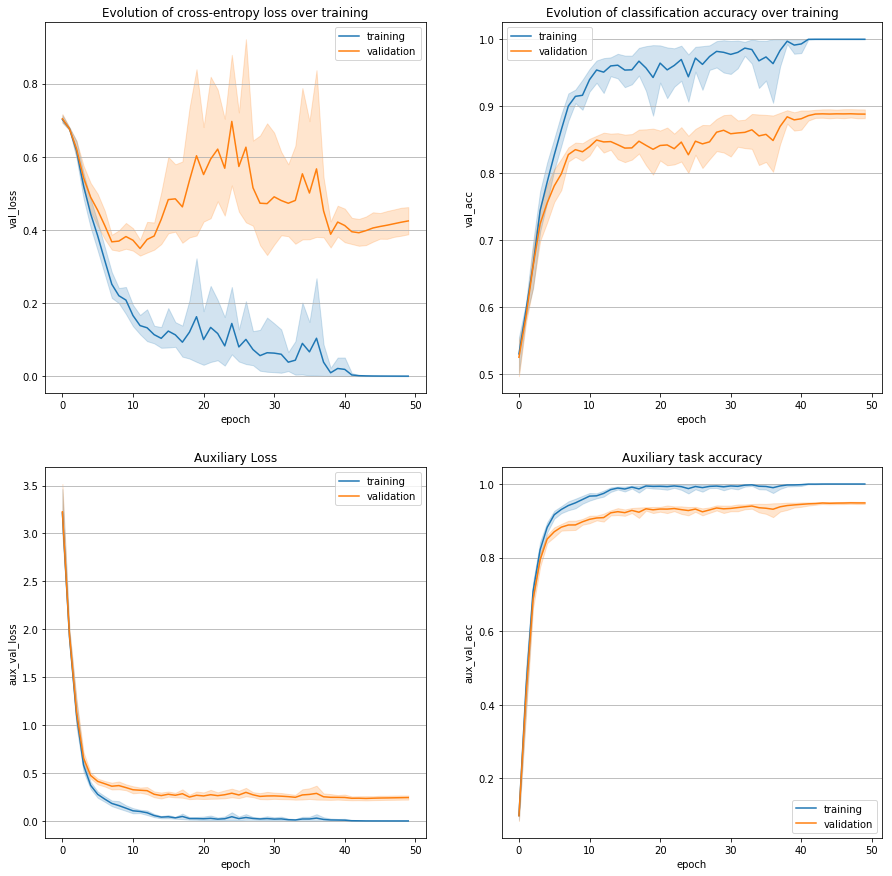

[52.80679481599509, 52.45158548699692, 52.00207341799978, 52.43024001500453, 52.098001333004504, 54.28439656599949, 52.672300735001045, 53.78817875200184, 52.0176015160032, 52.31370293600048]


In [13]:
#hNY.to_csv('./histories/conv_noWS_yesAux.csv', encoding='utf-8')
plot_hist(hNY, auxloss=True, savefig='conv_noWS_yesAux')
print(tNY)

### Weight sharing and auxiliary loss

In [9]:
tfYY = TrainingFramework(batchsize=100, mainLoss=nn.CrossEntropyLoss(), auxLoss=nn.CrossEntropyLoss())
hYY, tYY = tfYY.validateModel(lambda: ConvArch1(auxiliary_loss=True, weight_sharing=True))

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.00019,1.0,0.520104,0.8996,0.000240,1.0000,0.168891,0.96480,49
best,0.00052,1.0,0.470548,0.9016,0.000872,0.9999,0.162003,0.96395,35


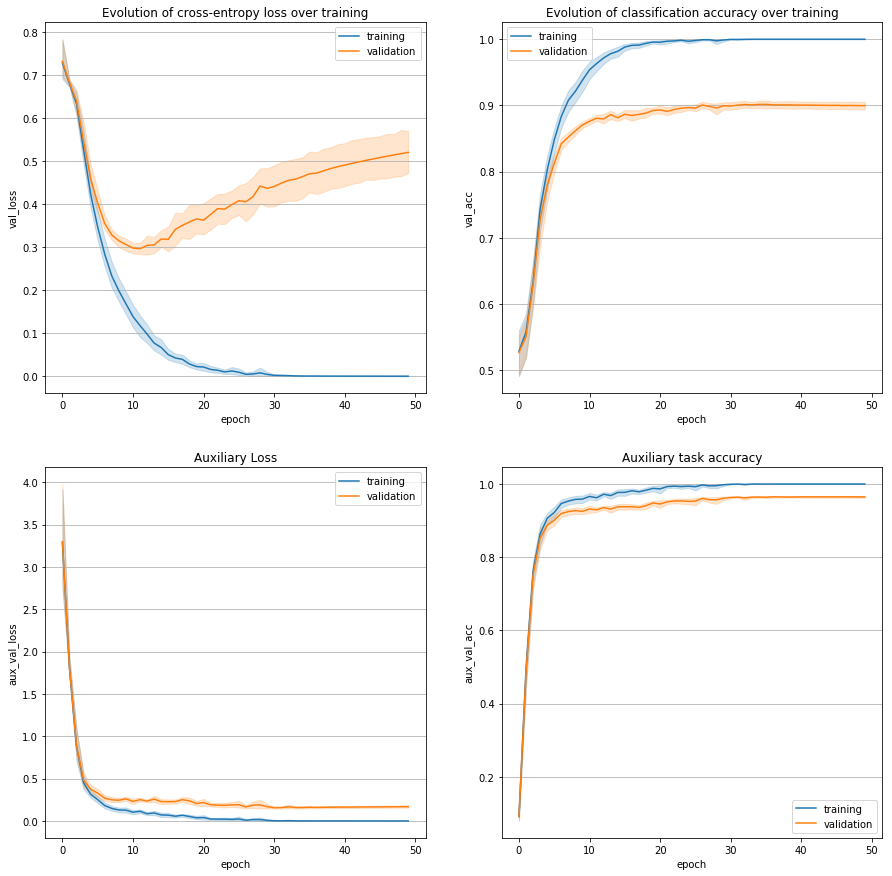

[52.19941915000527, 52.0236909860032, 51.93799819700507, 52.26437738799723, 52.0383701009996, 52.31159219099936, 51.79096753500198, 52.27345371700358, 52.25015733300097, 51.89740582500235]


In [14]:
#hYY.to_csv('./histories/conv_yesWS_yesAux.csv', encoding='utf-8')
plot_hist(hYY, auxloss=True, savefig='conv_yesWS_yesAux')
print(tYY)

In [15]:
hYY2, tYY2 = tfYY.validateModel(lambda: ConvArch1(auxiliary_loss=True, weight_sharing=True), auxLossWeight=0.75)

'Epoch 50/50'

,train_loss,train_acc,val_loss,val_acc,aux_train_loss,aux_train_acc,aux_val_loss,aux_val_acc,epoch
last,0.000882,1.0,0.432010,0.9009,0.000174,1.0,0.14776,0.96695,49
best,0.004411,1.0,0.361374,0.9025,0.000524,1.0,0.13630,0.96675,33


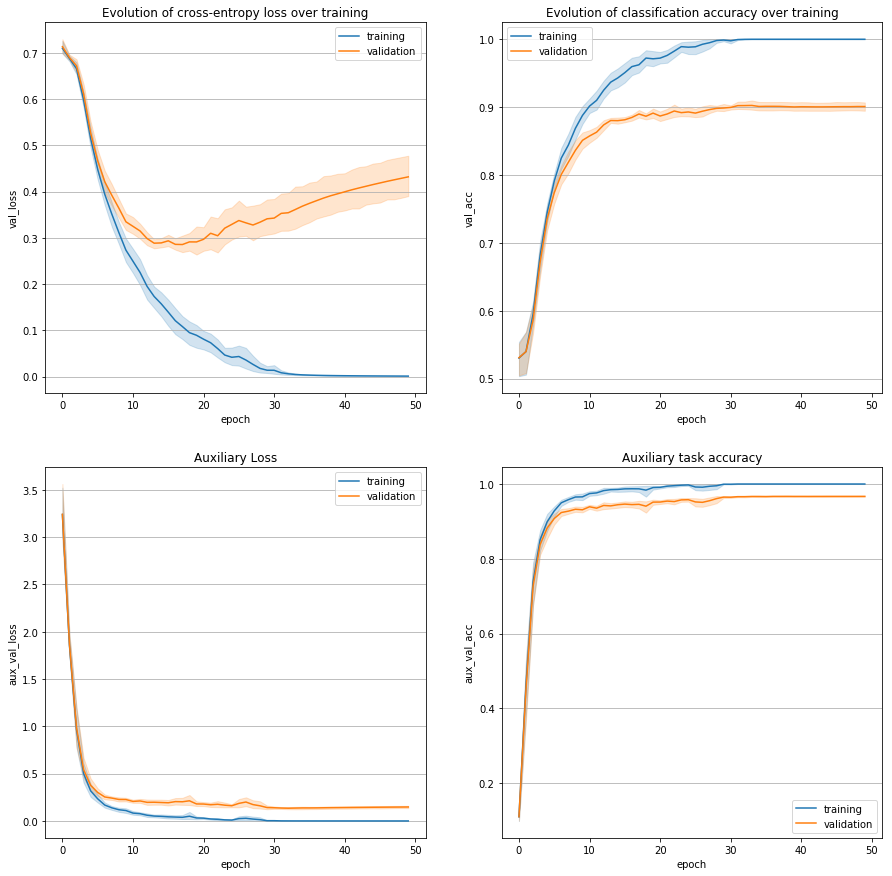

[56.83629547599412, 54.08579513999575, 59.509504656998615, 54.68240367399994, 54.652198223004234, 54.38845243900141, 54.746597639001266, 54.364753256006225, 54.80646654099837, 54.570258266001474]


In [16]:
#hYY.to_csv('./histories/conv_yesWS_yesAux.csv', encoding='utf-8')
plot_hist(hYY2, auxloss=True)#, savefig='conv_yesWS_yesAux')
print(tYY2)